# Predicting House Prices

**Sales prices prediction using an artificial neural network in Keras**

**Supervised Learning. Regression**

Source: Ames Housing dataset ([Kaggle website](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)).  

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import helper
import keras

helper.info_gpu()
sns.set_palette("GnBu_d")
#helper.reproducible(seed=0) # Setup reproducible results from run to run using Keras

Using TensorFlow backend.


/device:GPU:0
Keras		v2.1.3
TensorFlow	v1.4.1


## 1. Data Processing and Exploratory Data Analysis

In [2]:
data_path = 'data/house_prices_data.csv'
target = ['SalePrice']

df_original = pd.read_csv(data_path)
print("rows: {} \ncolumns: {} \ntarget: {}".format(*df_original.shape, target))

rows: 1460 
columns: 81 
target: ['SalePrice']


### Show original data

In [3]:
df_original.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


#### Missing values

['FireplaceQu', 'Fence', 'Alley', 'MiscFeature', 'PoolQC']

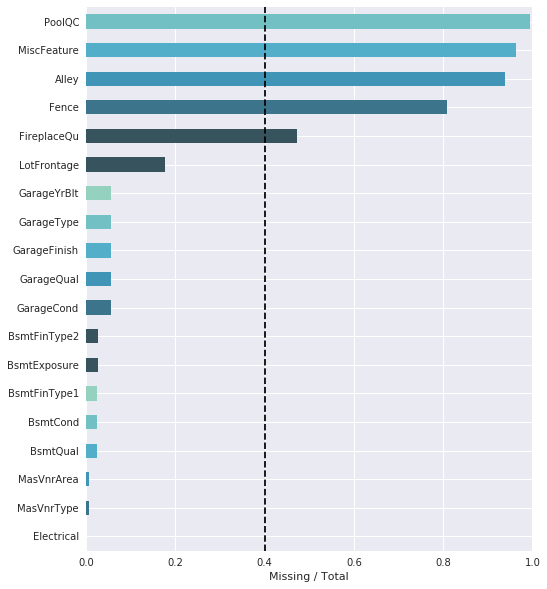

In [4]:
high_missing = helper.missing(df_original, limit=0.4, plot=True)
high_missing

### Transform the data

#### Remove irrelevant features

In [5]:
df = df_original.copy()  # modified dataset

# remove non-significant and high-missing features
droplist = ['Id'] + high_missing

assert len(set(droplist).intersection(set(target))) == 0, 'Targets cannot be dropped'

df.drop(droplist, axis='columns', inplace=True)

#### Classify variables

Change categorical variables as dtype 'categorical' and sort columns: numerical + categorical + target

In [6]:
numerical = list(df.select_dtypes(include=[np.number]))

df = helper.classify_data(df, target, numerical=numerical)

pd.DataFrame(dict(df.dtypes), index=["Type"])[df.columns].head()  # show data types

numerical features:   36
categorical features: 38
target 'SalePrice': float32


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,SalePrice
Type,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,...,category,category,category,category,category,category,category,category,category,float32


#### Remove low frequency values from categorical features

In [7]:
df, dict_categories = helper.remove_categories(df, target, ratio=0.01)

#### Fill missing values
Numerical -> median, categorical -> mode

In [8]:
helper.fill_simple(df, target, inplace=True)

### Visualize the data

(34900.0, 600000)

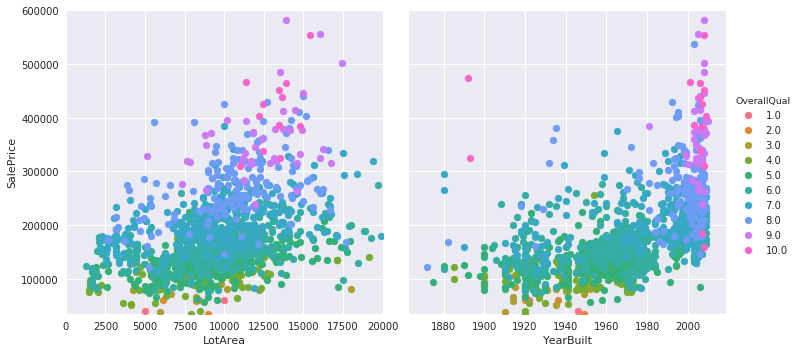

In [9]:
g = sns.PairGrid(df, y_vars=["SalePrice"], x_vars=["LotArea", "YearBuilt"], size=5, 
                 hue='OverallQual')
g.map(plt.scatter).add_legend()
g.axes[0, 0].set_xlim(0, 20000)
plt.ylim(df['SalePrice'].min(), 600000)

Lower sale prices are usually found in very low overall quality houses, with less dependency on its size and the year of construction. These three features alone are insufficient to make a good price prediction.

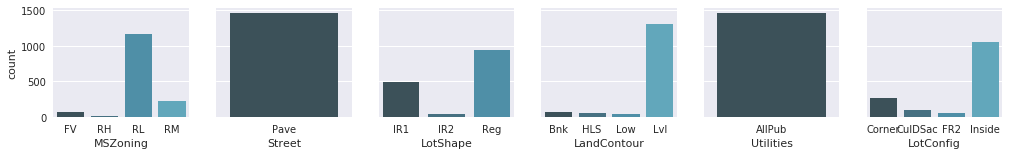

In [10]:
helper.show_categorical(df.iloc[:,36:42], sharey=True)

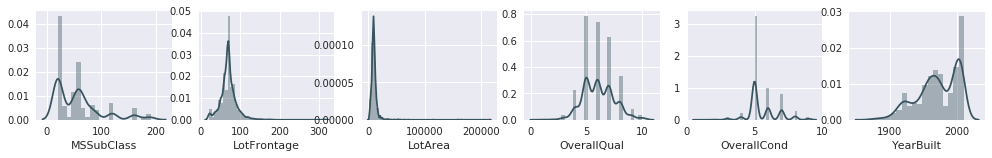

In [11]:
helper.show_numerical(df.iloc[:,:6], kde=True)

In [12]:
copy_df = df.copy()  # checkpoint

## 2. Neural Network model

### Select the features

In [13]:
droplist = []  # features to drop

df = copy_df.copy()  # Restore checkpoint

df.drop(droplist, axis='columns', inplace=True)
# From now use data instead of df
data = df.copy()
data.head(3)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,SalePrice
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,208500.0
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,181500.0
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,223500.0


### Standardize numerical variables
Shift and scale the variables such that they have zero mean and a standard deviation of 1

In [14]:
data, scale = helper.standardize(data)

/home/angel/anaconda3/envs/gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning:  Use new "scale" function
  """Entry point for launching an IPython kernel.


### Create dummy variables

In [15]:
# features only; target should be encoded later
data, dummies = helper.create_dummy(data, target)

# ordered neural network features (with dummies)
nn_features = [f for f in data if f not in target]

data.head(3)

/home/angel/anaconda3/envs/gpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Use new "replace_by_dummies" function
  


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.073350,-0.220800,-0.207071,0.651256,-0.517023,1.050633,0.878369,0.513928,0.575228,-0.288554,...,0,0,1,0,0,1,0,0,1,0
1,-0.872264,0.460162,-0.091855,-0.071812,2.178881,0.156680,-0.429428,-0.570555,1.171591,-0.288554,...,0,0,1,0,0,1,0,0,1,0
2,0.073350,-0.084607,0.073455,0.651256,-0.517023,0.984414,0.829932,0.325803,0.092875,-0.288554,...,0,0,1,0,0,1,0,0,1,0


### Split the data into training and test sets
Data leakage: Test set hidden when training the model, but seen when preprocessing the dataset

In [16]:
from sklearn.model_selection import train_test_split


def split(data, test_size=0.15):
    train, test = train_test_split(data, test_size=test_size, random_state=9)

    # Separate the data into features and target (x=features, y=target)
    x_train, y_train = train.drop(target, axis=1).values, train[target].values
    x_test, y_test = test.drop(target, axis=1).values, test[target].values
    # _nc: non-categorical yet (needs one-hot encoding)

    return x_train, y_train, x_test, y_test


x_train, y_train, x_test, y_test = split(data, test_size=0.2)

One-hot encode the output not needed for regression

In [17]:
print("train size \t X:{} \t Y:{}".format(x_train.shape, y_train.shape))
print("test size  \t X:{} \t Y:{} ".format(x_test.shape, y_test.shape))

train size 	 X:(1168, 192) 	 Y:(1168, 1)
test size  	 X:(292, 192) 	 Y:(292, 1) 


### Build the Neural Network for Regression

In [18]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout


def build_nn(input_size, output_size, summary=False):

    input_nodes = input_size // 2
    weights = keras.initializers.TruncatedNormal(stddev=0.0001)

    model = Sequential()

    model.add(
        Dense(
            input_nodes,
            input_dim=input_size,
            activation='relu',
            kernel_initializer=weights,
            bias_initializer=weights))
    
    model.add(Dropout(.2))

    model.add(
        Dense(
            1,
            activation=None,
            kernel_initializer=weights,
            bias_initializer=weights))

    opt = keras.optimizers.adam(lr=0.00005)
    model.compile(loss='mean_squared_error', optimizer=opt)

    if summary:
        model.summary()

    return model

### Train the Neural Network

Training ....
time: 	 15.1 s


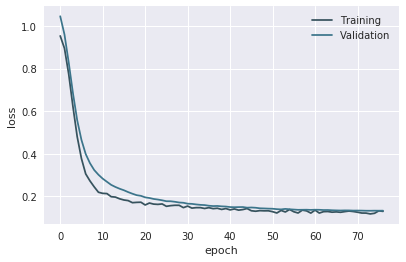


Training loss:  	0.1294
Validation loss: 	0.1326

Model saved at models/house_prices.h5


In [19]:
from time import time
model_path = os.path.join("models", "house_prices.h5")


def train_nn(model, x_train, y_train, validation_data=None, path=False, show=True):
    """ 
    Train the neural network model. If no validation_datais provided, a split for validation
    will be used
    """

    if show:
        print('Training ....')

    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=0)]
    t0 = time()

    history = model.fit(
        x_train,
        y_train,
        epochs=500,
        batch_size=16,
        validation_split=0.1,
        validation_data=validation_data,
        callbacks=callbacks,
        verbose=0)

    if show:
        print("time: \t {:.1f} s".format(time() - t0))
        helper.show_training(history)

    if path:
        model.save(path)
        print("\nModel saved at", path)

    return history


model = None
model = build_nn(x_train.shape[1], y_train.shape[1], summary=False)
train_nn(model, x_train, y_train, path=model_path)

### Train with Cross Validation

In [20]:
from sklearn.model_selection import KFold


def cv_train_nn(x_train, y_train, n_splits):
    """ Create and Train models for cross validation. Return best model """

    skf = KFold(n_splits=n_splits, shuffle=True)

    score = []

    best_model = None
    best_loss = float('inf')

    print('Training {} models for Cross Validation ...'.format(n_splits))

    for train, val in skf.split(x_train[:, 0], y_train[:, 0]):
        model = None
        model = build_nn(x_train.shape[1], y_train.shape[1], summary=False)
        history = train_nn(
            model,
            x_train[train],
            y_train[train],
            show=False,
            validation_data=(x_train[val], y_train[val]))

        val_loss = history.history['val_loss'][-1]

        score.append(val_loss)

        if val_loss < best_loss:  # save best model (fold) for evaluation and predictions
            best_model = model
            best_loss = val_loss

    print('\nCross Validation loss: {:.3f}'.format(np.mean(score)))
    return best_model


model = cv_train_nn(x_train, y_train, 10)

Training 10 models for Cross Validation ...

Cross Validation loss: 0.148


### Evaluate the model

In [21]:
def evaluate_nn(model, x_test, y_test):
    score = model.evaluate(x_test, y_test, verbose=0)
    print("\n Test loss: {:.4f}".format(score))


#model = keras.models.load_model(model_path)
evaluate_nn(model, x_test, y_test)


 Test loss: 0.1524


### Make predictions

SalePrice . Prediction error:
Mean: 	 -0.54%
Stddev:  10.97%


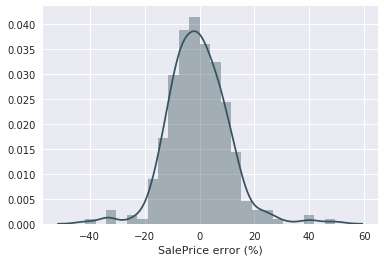

In [22]:
def predict_nn(model, x_test, target):
    """ Return a dataframe with actual and predicted targets in original scale"""

    for t in target:
        pred = model.predict(x_test, verbose=0)
        restore_pred = pred * scale[t][1] + scale[t][0]
        restore_pred = restore_pred.round()

        restore_y = y_test * scale[t][1] + scale[t][0]
        restore_y = restore_y.round()

        pred_label = 'Predicted_' + t
        error_label = t + ' error (%)'

        pred_df = pd.DataFrame({
            t: np.squeeze(restore_y),
            pred_label: np.squeeze(restore_pred)
        })

        pred_df[error_label] = ((pred_df[pred_label] - pred_df[t]) * 100 / pred_df[t]).round(1)

        print(t, ". Prediction error:")
        print("Mean: \t {:.2f}%".format(pred_df[error_label].mean()))
        print("Stddev:  {:.2f}%".format(pred_df[error_label].std()))
        sns.distplot(pred_df[error_label])

    return pred_df


pred_df = predict_nn(model, x_test, target)

In [23]:
pred_df.head(10)

,Predicted_SalePrice,SalePrice,SalePrice error (%)
0,214597.0,151400.0,41.700001
1,210940.0,241500.0,-12.700000
2,73537.0,82000.0,-10.300000
3,170000.0,162000.0,4.900000
4,144175.0,140000.0,3.000000
5,213670.0,227000.0,-5.900000
6,262100.0,228950.0,14.500000
7,190387.0,208300.0,-8.600000
8,118167.0,128500.0,-8.000000
9,166550.0,165000.0,0.900000


The error of the predicted sale prices can be modeled by a normal distribution, almost zero centered, and with a standard deviation of < 11%. Thus, ~95% of the houses are predicted within a price error < 22% respect to the actual one. 

Note: there is data leakage when removing low-frequency categorical values and scaling numerical features
